In [52]:
import os  # 导入操作系统模块
import numpy as np  # 导入numpy库并使用别名np
import cv2  # 导入OpenCV库
import matplotlib.pyplot as plt  # 导入matplotlib库并使用别名plt
import scipy  # 导入scipy库
from sklearn.neighbors import KNeighborsClassifier  # 从sklearn.neighbors模块导入KNeighborsClassifier类

In [53]:
# 读取图像数据
def read_images():
    file_name = "att_faces"  # 数据集文件夹名称
    data_directory = ""+file_name  # 数据集所在目录路径
    
    data = np.zeros((400,10304))  # 存储图像数据的数组
    labels = np.zeros((400,1))  # 存储标签的数组
    
    i=0  # 计数器
    for name in os.listdir(data_directory):  # 遍历数据集文件夹中的文件
        folderPath = os.path.join(data_directory,name)  # 拼接文件夹路径
        for ImageName in os.listdir(folderPath):  # 遍历每个文件夹中的图像文件
            Image_path = os.path.join(folderPath,ImageName)  # 拼接图像文件路径
            
            img = cv2.imread(Image_path,0)  # 读取灰度图像
            data[i,:] = img.flatten()  # 将图像展平并存储到data数组中
            labels[i] =  int(name)  # 将标签存储到labels数组中
            i+=1  # 计数器自增
    return data, labels  # 返回图像数据和标签

   
# 训练集和测试集划分
def train_test_split(data, labels):
    train_split_value = int(data.shape[0]*(5/10))  # 训练集大小
    test_split_value = data.shape[0] - train_split_value  # 测试集大小
    
    train_data = np.zeros((train_split_value,10304))  # 存储训练集图像数据的数组
    train_labels = np.zeros((train_split_value,1))  # 存储训练集标签的数组
    
    test_data = np.zeros((test_split_value,10304))  # 存储测试集图像数据的数组
    test_labels = np.zeros((test_split_value,1))  # 存储测试集标签的数组
    
    # 奇数行用于训练数据，偶数行用于测试数据
    i_train=0  # 训练数据计数器
    i_test=0  # 测试数据计数器
    for i in range(data.shape[0]):  # 遍历所有数据
        # 偶数行
        if i%2==0:  # 判断是否为偶数行
           test_data[i_test,:] = data[i]  # 将当前图像存储到测试数据数组中
           test_labels[i_test] = labels[i]  # 将当前标签存储到测试标签数组中
           i_test+=1  # 测试数据计数器自增
        # 奇数行
        else:
           train_data[i_train,:] = data[i]  # 将当前图像存储到训练数据数组中
           train_labels[i_train] = labels[i]  # 将当前标签存储到训练标签数组中
           i_train+=1  # 训练数据计数器自增
           
    return train_data, train_labels, test_data, test_labels  # 返回训练集和测试集数据及标签


In [54]:
# 计算每个类别的均值矩阵
def compute_classes_mean_matrix(train_data, train_labels):
    means = np.zeros((40,10304))  # 存储每个类别的均值矩阵
    train_test_split_ratio = 5  # 训练集与测试集的比例
    
    for i in range(1, 41):  # 遍历每个类别
        temp = np.where(train_labels == i)[0]  # 获取当前类别的训练数据索引
        temp_sum = np.zeros((1,10304))  # 存储当前类别的像素总和
        for j in range(train_test_split_ratio):  # 遍历当前类别的训练数据
           temp_sum += train_data[temp[j],:]  # 累加像素值
            
        means[i-1,:] = temp_sum / train_test_split_ratio  # 计算当前类别的均值
    return means  # 返回每个类别的均值矩阵

In [55]:
# 计算所有类别的整体均值矩阵
def compute_overall_mean_matrix(classes_means):
    temp_sum = np.zeros((1,10304))  # 存储像素总和
    for i in range(0,40):  # 遍历每个类别的均值矩阵
        temp_sum += classes_means[i,:]  # 累加像素值
    overall_mean = temp_sum / 40  # 计算整体均值
    
    return overall_mean.T  # 返回整体均值矩阵的转置

In [56]:
# 计算中心类别矩阵
def compute_center_class_matrix(train_data, train_labels, classes_means):
    Z = np.zeros(train_data.shape)  # 初始化中心类别矩阵
    
    for i in range(train_data.shape[0]):  # 遍历训练数据
        Z[i,:] = train_data[i,:] - classes_means[int(train_labels[i])-1,:]  # 计算中心类别矩阵

    return Z  # 返回中心类别矩阵

In [57]:
# 计算类间散布矩阵
def compute_between_class_scatter_matrix(classes_means, overall_mean):
    n = 5  # 训练集与测试集的比例
    Sb = np.zeros((classes_means.shape[1], classes_means.shape[1]))  # 初始化类间散布矩阵
    for i in range(classes_means.shape[0]):  # 遍历每个类别的均值矩阵
        Sb = np.add(Sb, n * ((classes_means[i] - overall_mean) * (classes_means[i] - overall_mean).T))  # 计算类间散布矩阵
    return Sb  # 返回类间散布矩阵

# 计算类内散布矩阵
def compute_class_scatter_matrix(Z):
    S = np.zeros((10304, 10304))  # 初始化类内散布矩阵
    S = np.dot(Z.T, Z)  # 计算类内散布矩阵
    return S  # 返回类内散布矩阵

In [58]:
# 绘制准确率图表
def plot_accuracy_graph(accuracy):
    plt.figure(figsize=(12, 6))  # 设置图表大小
    plt.plot(range(1, 25), accuracy, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)  # 绘制准确率图线
    plt.ylim(50, 100)  # 设置y轴范围
    plt.title('Accuracy for each K Value')  # 设置图表标题
    plt.xlabel('K Value')  # 设置x轴标签
    plt.ylabel('Accuracy %')  # 设置y轴标签

In [59]:
# 数据降维
def data_dimencionality_reduction(train_data, test_data, eigen_vectors):
    train_data_dimensionally_reductuted = np.zeros((200, 40))  # 存储训练数据降维后的数组
    test_data_dimensionally_reductuted = np.zeros((200, 40))  # 存储测试数据降维后的数组
    
    i = 0  # 计数器
    for img in train_data:  # 遍历训练数据
        train_data_dimensionally_reductuted[i,:] = np.dot(img, eigen_vectors)  # 计算训练数据的降维结果
        i += 1  # 计数器自增
    i = 0  # 重置计数器
    for img in test_data:  # 遍历测试数据
        test_data_dimensionally_reductuted[i,:] = np.dot(img, eigen_vectors)  # 计算测试数据的降维结果
        i += 1  # 计数器自增
        
    return train_data_dimensionally_reductuted, test_data_dimensionally_reductuted  # 返回降维后的训练数据和测试数据


In [60]:
data, labels = read_images()  # 读取图像数据和标签
print('Done images reading')  # 输出提示信息

train_data, train_labels, test_data, test_labels = train_test_split(data, labels)  # 划分训练集和测试集
print('Done Train Test Split')  # 输出提示信息

classes_means = compute_classes_mean_matrix(train_data, train_labels)  # 计算每个类别的均值矩阵
print('Done classes means computing')  # 输出提示信息

overall_mean = compute_overall_mean_matrix(classes_means)  # 计算整体均值矩阵
print('Done overall mean computing')  # 输出提示信息

S_between = compute_between_class_scatter_matrix(classes_means, overall_mean)  # 计算类间散布矩阵
print('Done between class scater matrix computing')  # 输出提示信息

Z = compute_center_class_matrix(train_data, train_labels, classes_means)  # 计算中心类别矩阵
print('Done center class scatter matrix computing')  # 输出提示信息

S_classes = compute_class_scatter_matrix(Z)  # 计算类内散布矩阵
print('Done within class scatter matrix computing')  # 输出提示信息

W_value = np.dot(np.linalg.inv(S_classes), S_between)  # 计算投影矩阵W
print('Done W = S^(-1)B computing')  # 输出提示信息

# 提取前40个最大特征值对应的特征向量
eigen_values, eigen_vectors = scipy.linalg.eigh(W_value, eigvals=((10304-40),(10304-1)))  # 计算特征值和特征向量
print('Done eigen values and vectors computing')  # 输出提示信息



Done images reading
Done Train Test Split
Done classes means computing
Done overall mean computing


Done between class scater matrix computing
Done center class scatter matrix computing
Done within class scatter matrix computing
Done W = S^(-1)B computing
Done eigen values and vectors computing


In [61]:
# 计算线性判别函数 d(Q)
def compute_linear_discriminant_function(W, query, overall_mean):
    # 计算 d(Q) = W^T (Q - P)
    return np.dot(W.T, (query - overall_mean))

# 计算欧几里得范数 ||d||
def compute_euclidean_distance(d):
    return np.linalg.norm(d)

# 测试已存在类别的样本图像
def test_existing_class_sample(W, query_image, overall_mean, train_data, train_labels):
    # 计算查询图像的线性判别函数值
    d = compute_linear_discriminant_function(W, query_image, overall_mean)
    # 计算欧几里得范数
    euclidean_distances = []
    for i in range(train_data.shape[0]):
        train_image = train_data[i]
        train_d = compute_linear_discriminant_function(W, train_image, overall_mean)
        euclidean_distance = compute_euclidean_distance(d - train_d)
        euclidean_distances.append(euclidean_distance)
    # 找到匹配的样本图像索引
    best_match_index = np.argmin(euclidean_distances)
    # 返回匹配结果
    return train_data[best_match_index], euclidean_distances[best_match_index]


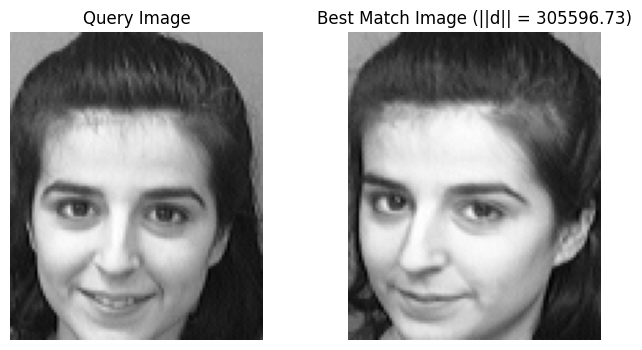

In [62]:
# 测试已存在类别的样本图像
query_image = test_data[5]  # 取测试集中的图像
best_match_image, min_distance = test_existing_class_sample(eigen_vectors, query_image, overall_mean, train_data, train_labels)

# 可视化测试图像和最佳匹配图像
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(query_image.reshape((112, 92)), cmap='gray')
axes[0].set_title('Query Image')
axes[0].axis('off')
axes[1].imshow(best_match_image.reshape((112, 92)), cmap='gray')
axes[1].set_title(f'Best Match Image (||d|| = {min_distance:.2f})')
axes[1].axis('off')
plt.show()

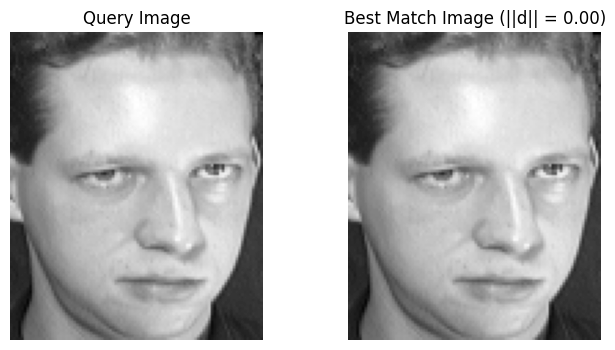

In [63]:
# 测试训练集的样本图像
query_image = train_data[0]  # 取训练集中的图像
best_match_image, min_distance = test_existing_class_sample(eigen_vectors, query_image, overall_mean, train_data, train_labels)

# 可视化测试图像和最佳匹配图像
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(query_image.reshape((112, 92)), cmap='gray')
axes[0].set_title('Query Image')
axes[0].axis('off')
axes[1].imshow(best_match_image.reshape((112, 92)), cmap='gray')
axes[1].set_title(f'Best Match Image (||d|| = {min_distance:.2f})')
axes[1].axis('off')
plt.show()

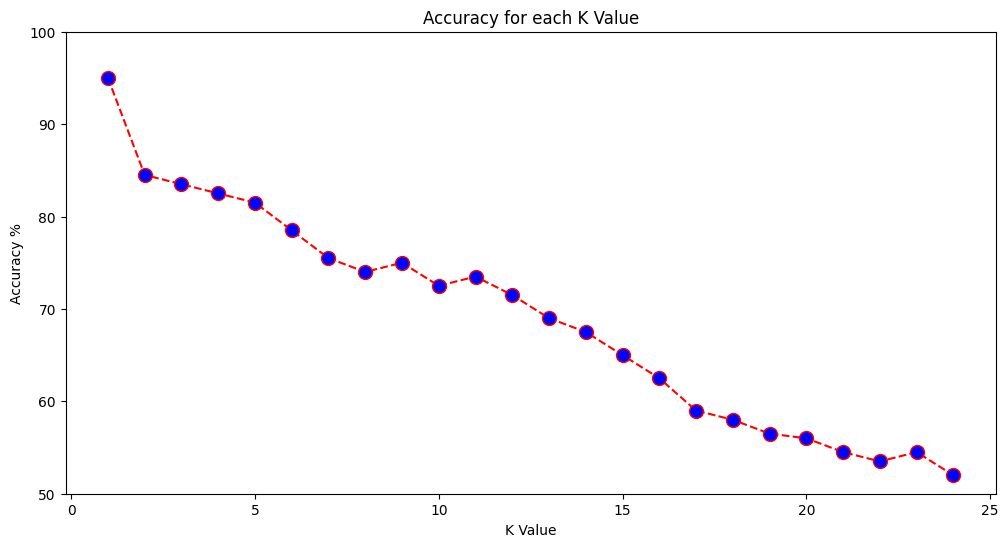

In [64]:
# 降维处理
train_data_dimensionally_reductuted, test_data_dimensionally_reductuted = data_dimencionality_reduction(train_data, test_data, eigen_vectors)  # 数据降维处理
    
accuracy = []  # 存储准确率
# 应用KNN算法
for i in range(1, 25):  # 遍历K值
    classifier = KNeighborsClassifier(n_neighbors=i)  # 创建KNN分类器
    classifier.fit(train_data_dimensionally_reductuted, train_labels)  # 拟合训练数据
        
    test_predict = classifier.predict(test_data_dimensionally_reductuted)  # 对测试数据进行预测
        
    true_predicted_count = 0  # 统计正确预测的数量
    for j in range(0, 200):  # 遍历测试数据
        if test_predict[j] == test_labels[j]:  # 判断是否预测正确
            true_predicted_count += 1  # 统计正确预测数量
    accuracy.append((true_predicted_count / 200) * 100)  # 计算准确率并存储
    
# 绘制不同K值下的准确率图表
plot_accuracy_graph(accuracy) 